In [1]:
import sys, os, yaml
sys.path.append('../')
import torch
import numpy as np
import deepxde as dde
from inverse_model import InverseModel
import argparse
from utils import visualize
from models import inverse_net

device = torch.device('cuda:0')

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
project_dir = '../weights/case1b'
config = '../config/case1b.yaml'

model_dir = os.path.join(project_dir, 'best_train_loss_model.pt')


params_label = ['k','c']
regl_case = 'case1'

args = argparse.ArgumentParser().parse_args('')
with open(config, 'r') as f:
    config = yaml.safe_load(f)
    for key, value in config.items():
                setattr(args, key, value)
                
epoch = 5000
lr = 0.1
run = 5
batch_size = 64

setattr(args, 'epoch', epoch)
setattr(args, 'lr', lr)
setattr(args, 'run', run)
setattr(args, 'eval_type', 'inverse_eval')
setattr(args, 'seed', None)
setattr(args, 'batch_size', batch_size)
setattr(args, 'project_dir', project_dir)
setattr(args, 'regl_case', regl_case)

inverse_trainer = InverseModel(args)
inverse_trainer.create_eval_dir()
inverse_trainer.load_weights(weight_path=model_dir)

The model is set to be:  ParametricDeepONet
The decoder mode is:  nonlinear
The depth of the model is:  3
The width of the model is:  300
Seed is randomly set to be:  1446


In [3]:
total_train_params = []
for i in range(run):
    pred_train_params = inverse_trainer.gradient_init(data=inverse_trainer.train_data, batch_size=batch_size, epoch=epoch, forward_net = inverse_trainer.model, check_int = 1000, regl_case=regl_case, lr=lr)
    total_train_params.append(pred_train_params)

mean_train_params = torch.mean(torch.stack(total_train_params), dim=0)
std_train_pred_params = torch.std(torch.stack(total_train_params), dim=0)
inverse_trainer.evaluate_record['train_pred_params'] = mean_train_params
inverse_trainer.evaluate_record['train_pred_params_std'] = std_train_pred_params
post_pi_data = mean_train_params, inverse_trainer.train_data[0], inverse_trainer.train_data[1], inverse_trainer.train_data[2], inverse_trainer.train_data[3]
inverse_trainer.post_pi_train_data = post_pi_data
inverse_trainer.post_pi_train_dataset = torch.utils.data.TensorDataset(post_pi_data[0], post_pi_data[1], post_pi_data[2], post_pi_data[3], post_pi_data[4])

total_test_params = []
for i in range(run):
    pred_test_params = inverse_trainer.gradient_init(data=inverse_trainer.test_data, batch_size=batch_size, epoch=epoch, forward_net=inverse_trainer.model, check_int = 1000, regl_case=regl_case, lr=lr)
    total_test_params.append(pred_test_params)
    
mean_test_params = torch.mean(torch.stack(total_test_params), dim=0)
std_test_pred_params = torch.std(torch.stack(total_test_params), dim=0)
inverse_trainer.evaluate_record['test_pred_params'] = mean_test_params
inverse_trainer.evaluate_record['test_pred_params_std'] = std_test_pred_params

post_pi_data = mean_test_params, inverse_trainer.test_data[0], inverse_trainer.test_data[1], inverse_trainer.test_data[2], inverse_trainer.test_data[3]
inverse_trainer.post_pi_test_data = post_pi_data

Normalized RMSE of test mu:  tensor([0.0215, 0.0267], device='cuda:0', grad_fn=<SqrtBackward0>)
NRMSE: 2.150e-02


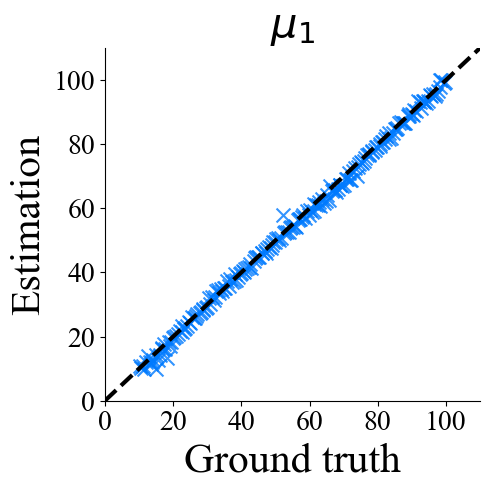

NRMSE: 2.671e-02


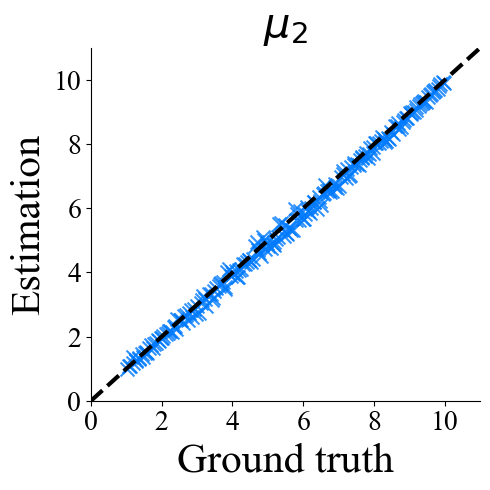

In [4]:
metrics = inverse_trainer.evaluate_metrics(mode='GI', data = 'test')
params_meaning = ['Stiffness','Damping'] 
for i, label in enumerate(params_label): 
    if i == 0:
        axis_label = True
    else:
        axis_label = False
    visualize.plot_case1_params_scatter(params_group_1 = inverse_trainer.test_data[1][:,i].unsqueeze(1),
                                        params_group_pred_1 = mean_test_params[:,i].unsqueeze(1),
                                        std_params_group_pred_1 = std_test_pred_params[:,i],
                                        params_group_2 = torch.tensor([]),
                                        params_group_pred_2= torch.tensor([]),
                                        std_params_group_pred_2 = torch.tensor([]),
                                        label=params_meaning[i],
                                        title='$\mu_{}$'.format(i+1),
                                        save_as = os.path.join(inverse_trainer.save_dir,'gi_case1b_{}.png'.format(label)), errorbar = True,
                                        metrics=metrics)

In [5]:
post_train_data_loader = torch.utils.data.DataLoader(inverse_trainer.post_pi_train_dataset, batch_size=64, shuffle=True, generator=torch.Generator(inverse_trainer.device))
    
epoch = 200
iterative_steps = 1
iter_memory = 0
lr = 0.001

class IRNet(inverse_net.InitialRefineNet):
    def __init__(self):
        super(IRNet, self).__init__()
        self.gradient_nn = dde.nn.FNN([(iter_memory + 2) * 2, 64, 64, (iter_memory+1) * 2], 'relu', 'Glorot normal')
random_seed = np.random.randint(0,10000)
torch.manual_seed(random_seed)
print('Random Seed:', random_seed)
inverse_refine_net = IRNet()
optimizer = torch.optim.Adam(inverse_refine_net.parameters(), lr=lr)
scheduler = ''

inverse_trainer.iterative_refine(ir_net = inverse_refine_net, 
                            optimizer = optimizer,
                            forward_model = inverse_trainer.model, 
                            data_loader= post_train_data_loader,
                            check_int = 1, epochs = epoch, iter_steps = iterative_steps, memory_iter = iter_memory, regl_case = regl_case, data_case='case1')


Random Seed: 1841


In [6]:
test_mu_refine, _ = inverse_trainer.iteratively_update_mu(forward_model = inverse_trainer.model, ir_net= inverse_refine_net, x_t = inverse_trainer.post_pi_test_data[1], mu_hat_0= inverse_trainer.post_pi_test_data[0] , y_t = inverse_trainer.post_pi_test_data[3], ts = inverse_trainer.post_pi_test_data[4], iter_steps = iterative_steps, memory_iter = iter_memory, regl_case = regl_case)
train_mu_refine, _ = inverse_trainer.iteratively_update_mu(forward_model = inverse_trainer.model, ir_net= inverse_refine_net, x_t = inverse_trainer.post_pi_train_data[1], mu_hat_0= inverse_trainer.post_pi_train_data[0] , y_t = inverse_trainer.post_pi_train_data[3], ts = inverse_trainer.post_pi_train_data[4], iter_steps = iterative_steps, memory_iter = iter_memory, regl_case = regl_case)

Normalized RMSE of test mu:  tensor([0.0186, 0.0207], device='cuda:0', grad_fn=<SqrtBackward0>)
NRMSE: 1.861e-02


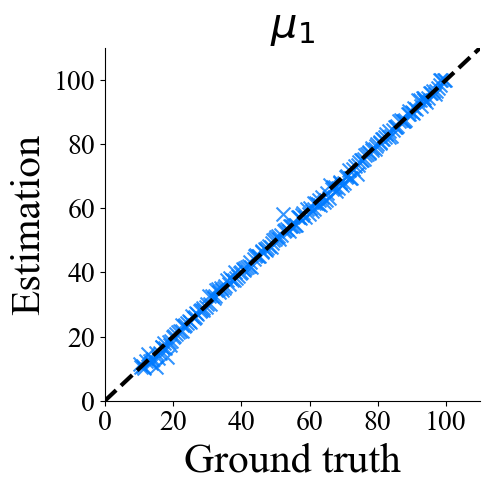

NRMSE: 2.065e-02


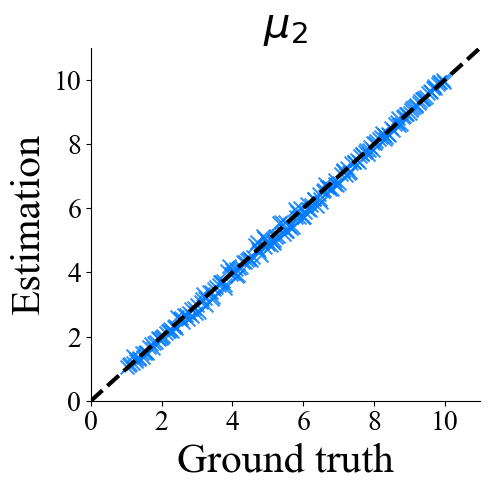

In [7]:
params_meaning = ['Stiffness','Damping']

metrics = inverse_trainer.evaluate_metrics(mode='NR', data = 'test')
for i, label in enumerate(params_label): 
    visualize.plot_case1_params_scatter(params_group_1 = inverse_trainer.test_data[1][:,i].unsqueeze(1),
                        params_group_pred_1 = inverse_trainer.ir_test_params[:,i].unsqueeze(1),
                        std_params_group_pred_1 = torch.tensor([]),
                        params_group_2 = torch.tensor([]),
                        params_group_pred_2= torch.tensor([]),
                        std_params_group_pred_2 = torch.tensor([]),
                        label=params_meaning[i],
                        title='$\mu_{}$'.format(i+1),
                        save_as = os.path.join(inverse_trainer.save_dir,'nr_case1b_{}.png'.format(label)),errorbar=False, metrics=metrics)